In [ ]:
# !pip install opencv-python
# !pip install pafy
# !pip install numpy
# !pip install tensorflow


In [19]:
weightspath= '/content/drive/MyDrive/HDMB51/Weights/Model2Weights.zip' #specify the location for the model weights
datapath = '/content/drive/MyDrive/HDMB51/HDMP51_converted.zip'  #specify where the data is in your Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the required libraries.
import os
import cv2

import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# CHANGE FILE HERE

In [46]:
#Specifying the random test video
checkvid2 = '/content/punch.mp4'
#Defining PAth
dataclasspath = '/content/Data/content/Dataset/Converted'

#Importing the test dataset:

[fill in information about the dataset we are using (number of classes, frame height width, avg number of frames etc)]



In [ ]:
# # Downlaod the UCF50 Dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
# #Extract the Dataset
#!unrar x UCF50.rar

In [5]:
!unzip '/content/drive/MyDrive/HDMB51/HDMP51_converted.zip' -d '/content/Data'

Streaming output truncated to the last 5000 lines.
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/THE_PROTECTOR_fall_floor_f_cm_np1_ri_bad_73.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/RATRACE_fall_floor_f_cm_np1_fr_med_2.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/TheBoondockSaints_turn_u_nm_np1_fr_med_31.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/Pushups_Workout__Push_Up_protein__Part_One_pushup_f_cm_np1_le_bad_3.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/Price_giving_ceremony_hug_f_cm_np2_le_med_0.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/Pirates_4_turn_h_nm_np1_ba_med_1.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/St__Louis_Goalkeeping__Academy_elite_training_jump_f_nm_np1_le_bad_13.mp4  
 extracting: /content/Data/content/Dataset/Converted/Watch_Out/Basketball_Training-_Amazing_3_ball_and_4_ball_dribbling_dribble_

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

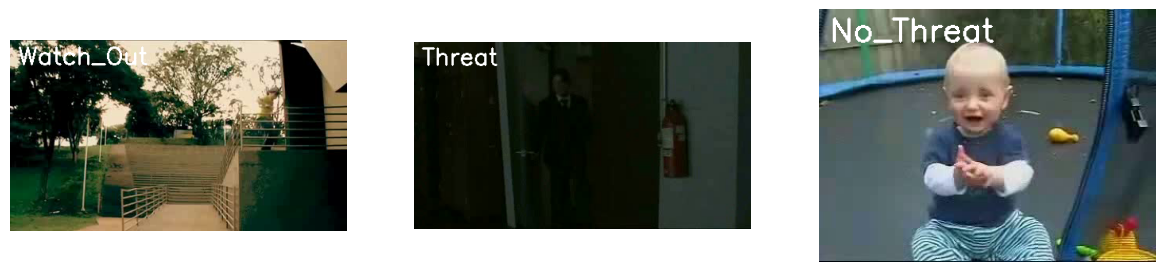

In [6]:

plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('/content/Data/content/Dataset/Converted')

random_range = random.sample(range(len(all_classes_names)), 3)


for counter, random_index in enumerate(random_range, 1):


    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/content/Data/content/Dataset/Converted/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/content/Data/content/Dataset/Converted/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
#all related class names
classes_names = os.listdir(dataclasspath)
classes_names

['No_Threat', 'Threat', 'Watch_Out']

In [8]:
#################################CHanged Here#######################
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "/content/Data/content/Dataset/Converted"
CLASSES_LIST = ['Watch_Out', 'No_Threat', 'Threat']


In [9]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [10]:
def create_dataset():


    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [11]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Watch_Out
Extracting Data of Class: No_Threat
Extracting Data of Class: Threat


In [12]:
  # Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [13]:
# Split the Data into Train  and Test Set ( 3:1 ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [14]:
def create_convlstm_model():



    model = Sequential()


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))


    model.summary()


    return model

In [15]:

convlstm_model = create_convlstm_model()


print("Model Created")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

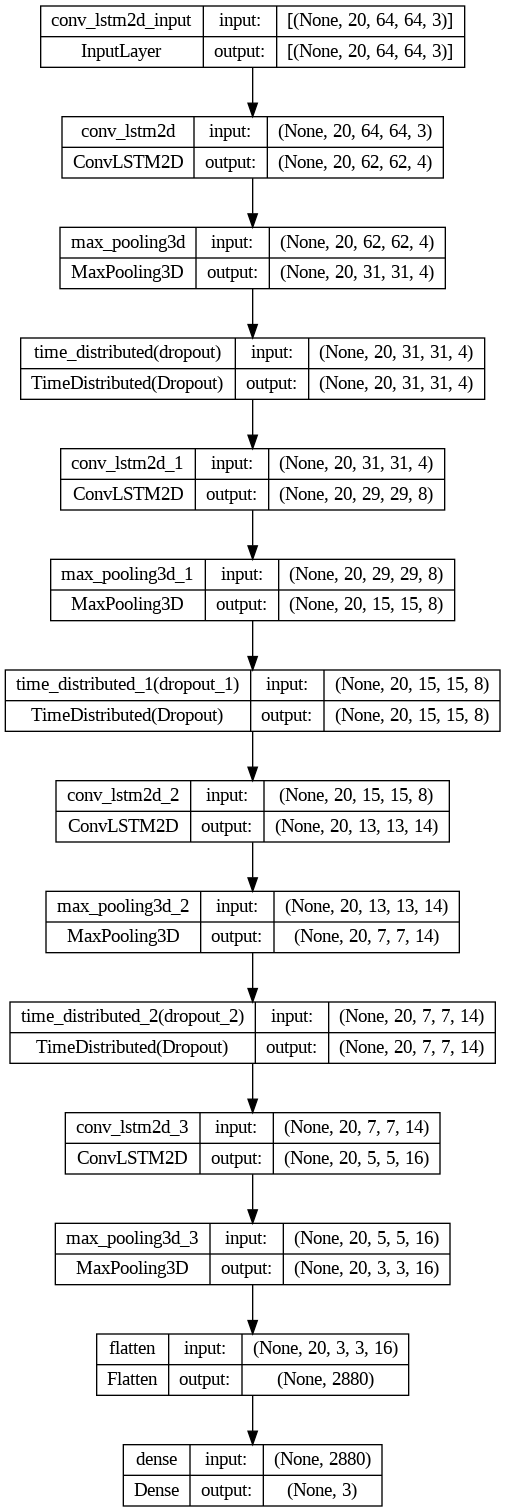

In [16]:

plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [18]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
###Model training###
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 8,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

In [21]:
!unzip {weightspath} -d '/content/weights'

Archive:  /content/drive/MyDrive/HDMB51/Weights/Model2Weights.zip
 extracting: /content/weights/content/Model weights/Convlstm model/keras_metadata.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/fingerprint.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/saved_model.pb  
 extracting: /content/weights/content/Model weights/Convlstm model/variables/variables.data-00000-of-00001  
 extracting: /content/weights/content/Model weights/Convlstm model/variables/variables.index  
 extracting: /content/weights/content/Model weights/LRCNmodel/keras_metadata.pb  
 extracting: /content/weights/content/Model weights/LRCNmodel/fingerprint.pb  
 extracting: /content/weights/content/Model weights/LRCNmodel/saved_model.pb  
 extracting: /content/weights/content/Model weights/LRCNmodel/variables/variables.data-00000-of-00001  
 extracting: /content/weights/content/Model weights/LRCNmodel/variables/variables.index  


In [22]:
tf.keras.models.load_model('/content/weights/content/Model weights/Convlstm model')

In [23]:

model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

15/15 [==============================] - 3s 71ms/step - loss: 1.0895 - accuracy: 0.5546


In [24]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)


model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'


convlstm_model.save(model_file_name)

In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))


    plt.legend()

In [ ]:
convlstm_model.save('/content/Model weights/Convlstm model')

In [ ]:

plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:

plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [28]:
def create_LRCN_model():

    model = Sequential()


    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model

In [29]:

LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

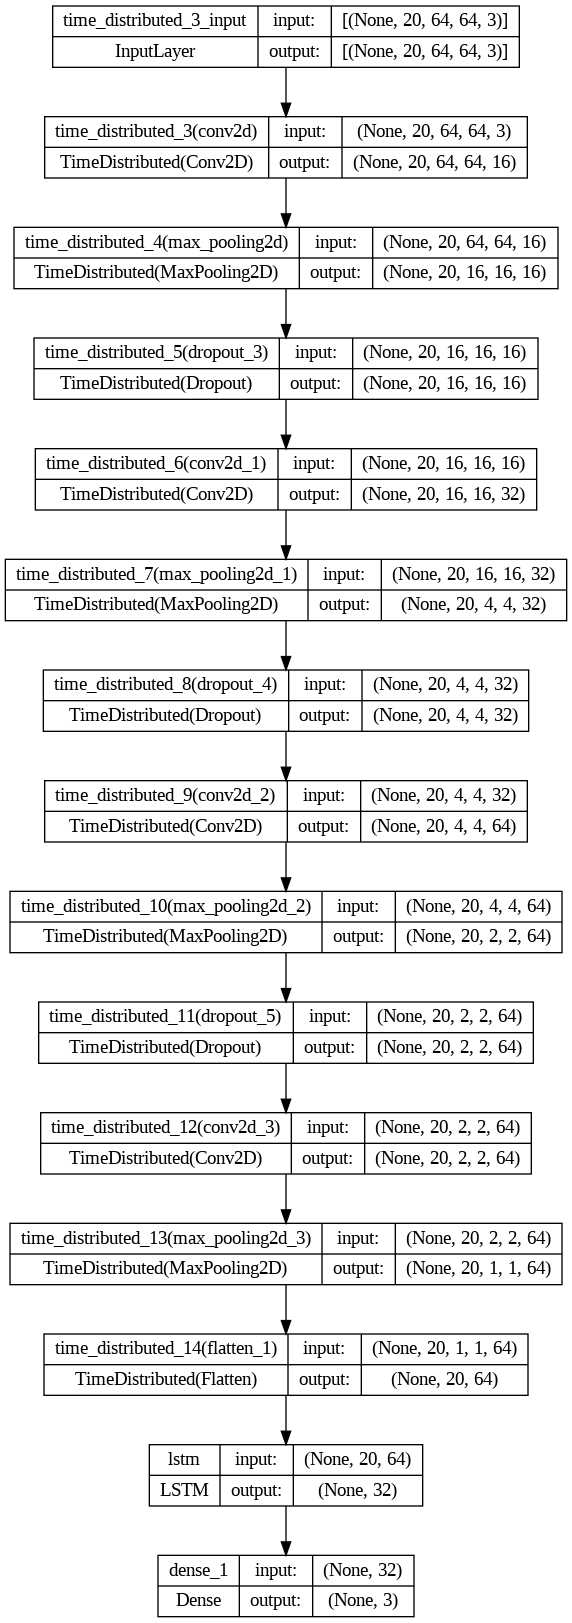

In [30]:

plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [31]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:


LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
274/274 [==============================] - 7s 11ms/step - loss: 0.9412 - accuracy: 0.6186 - val_loss: 0.9206 - val_accuracy: 0.6182
Epoch 2/70
274/274 [==============================] - 2s 8ms/step - loss: 0.9154 - accuracy: 0.6186 - val_loss: 0.9076 - val_accuracy: 0.6182
Epoch 3/70
274/274 [==============================] - 2s 8ms/step - loss: 0.9042 - accuracy: 0.6186 - val_loss: 0.9054 - val_accuracy: 0.6182
Epoch 4/70
274/274 [==============================] - 2s 9ms/step - loss: 0.8999 - accuracy: 0.6186 - val_loss: 0.8891 - val_accuracy: 0.6182
Epoch 5/70
274/274 [==============================] - 2s 8ms/step - loss: 0.8844 - accuracy: 0.6186 - val_loss: 0.8895 - val_accuracy: 0.6182
Epoch 6/70
274/274 [==============================] - 2s 8ms/step - loss: 0.8629 - accuracy: 0.6186 - val_loss: 0.9059 - val_accuracy: 0.6182
Epoch 7/70
274/274 [==============================] - 2s 8ms/step - loss: 0.8731 - accuracy: 0.6186 - val_loss: 0.8552 - val_accuracy: 0.6182
Epoch

In [33]:
tf.keras.models.load_model('/content/weights/content/Model weights/LRCNmodel')

In [34]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

15/15 [==============================] - 2s 25ms/step - loss: 1.1291 - accuracy: 0.1878


In [36]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'



In [ ]:
LRCN_model.save(model_file_name)

In [ ]:

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
LRCN_model.save('/content/Model weights/LRCNmodel')

In [ ]:
# def download_youtube_videos(youtube_video_url, output_directory):



#      video = pafy.new(youtube_video_url)


#      title = video.title

#      # Get the best available quality object for the video.
#      video_best = video.getbest()

#      # Construct the output file path.
#      output_file_path = f'{output_directory}/{checkvid}'

#      # Download the youtube video at the best available quality and store it to the contructed path.
#      video_best.download(filepath = output_file_path, quiet = True)

#      # Return the video title.
#      return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [37]:
# Make the Output directory if it does not exist

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = '/content/cycl.mp4'
input_video_file_path
video_title = checkvid

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [53]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()
    return predicted_class_name

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [56]:
# RUN THIS -1
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}'#-Output-SeqLen{SEQUENCE_LENGTH}.mp4'



# Perform Action Recognition on the Test Video.
#predict_on_video(checkvid2, output_video_file_path, SEQUENCE_LENGTH)
s = predict_on_video(checkvid2, output_video_file_path, SEQUENCE_LENGTH)
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 22ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [57]:
s

'Threat'

##.

In [ ]:
import zipfile

# Create a ZipFile object
with zipfile.ZipFile('Model2Weights.zip', 'w') as zip_file:

    # Add the folder to the ZipFile object
    for root, dirs, files in os.walk('/content/Model weights'):
        for file in files:
            zip_file.write(os.path.join(root, file))